In [1]:
import pandas as pd
import numpy as np
import os
import glob

import PIL
from PIL import Image
import imageio

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import seaborn as sn
import numpy as np
import pathlib

In [2]:
from google.colab import files
files.upload()

Saving Brain tumor.zip to Brain tumor.zip


In [3]:
!unzip Brain\ tumor.zip

Archive:  Brain tumor.zip
   creating: Brain tumor/Br35H-Mask-RCNN/
  inflating: Brain tumor/Br35H-Mask-RCNN/annotations_all.json  
   creating: Brain tumor/Br35H-Mask-RCNN/TEST/
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Brain tumor/Br35H-Mask-RCNN/TEST/y713.jpg  
  inflatin

In [4]:
data_dir = '/content/Brain tumor'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Image Count: ",image_count)

Image Count:  3060


In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3167 files belonging to 4 classes.
Using 2534 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3167 files belonging to 4 classes.
Using 633 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Br35H-Mask-RCNN', 'no', 'pred', 'yes']


In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
num_classes = 8

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 8, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 8, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 8, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(255, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=8
)

Epoch 1/8
80/80 [==============================] - 448s 6s/step - loss: 0.9370 - accuracy: 0.6401 - val_loss: 0.6625 - val_accuracy: 0.7615
Epoch 2/8
80/80 [==============================] - 424s 5s/step - loss: 0.6247 - accuracy: 0.7739 - val_loss: 0.5475 - val_accuracy: 0.8278
Epoch 3/8
80/80 [==============================] - 424s 5s/step - loss: 0.5244 - accuracy: 0.8078 - val_loss: 0.4851 - val_accuracy: 0.8578
Epoch 4/8
80/80 [==============================] - 425s 5s/step - loss: 0.4237 - accuracy: 0.8556 - val_loss: 0.4778 - val_accuracy: 0.8562
Epoch 5/8
80/80 [==============================] - 423s 5s/step - loss: 0.3344 - accuracy: 0.8883 - val_loss: 0.4450 - val_accuracy: 0.8578
Epoch 6/8
80/80 [==============================] - 412s 5s/step - loss: 0.2811 - accuracy: 0.9092 - val_loss: 0.4525 - val_accuracy: 0.8720
Epoch 7/8
80/80 [==============================] - 407s 5s/step - loss: 0.2435 - accuracy: 0.9187 - val_loss: 0.3961 - val_accuracy: 0.8910
Epoch 8/8
80/80 [===

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 173, 173, 32)      6176      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 79, 79, 32)        65568     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        65568     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)       

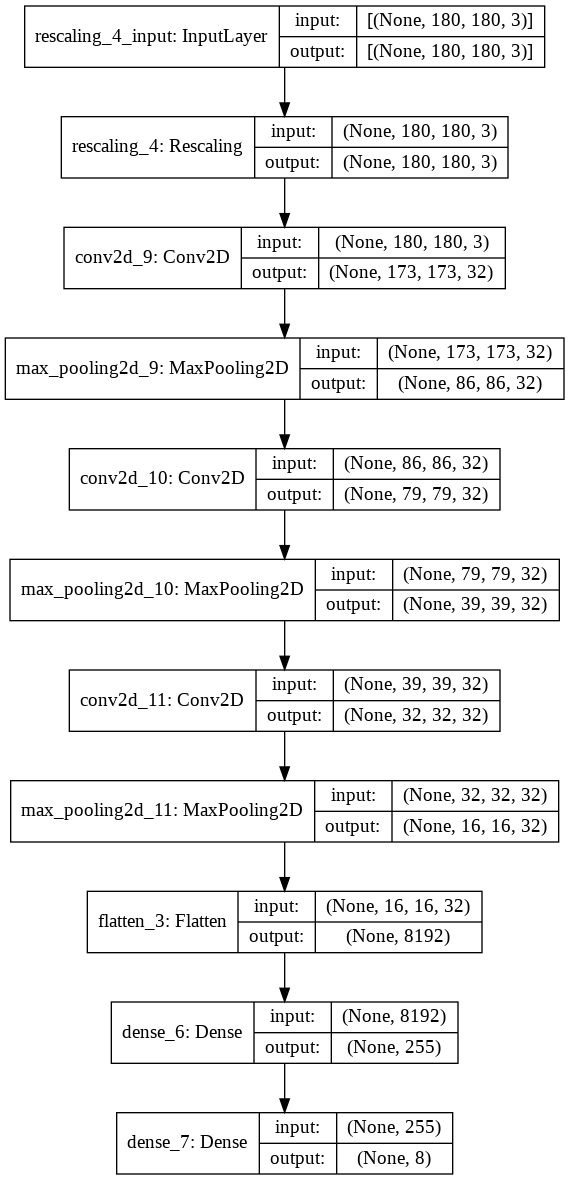

In [16]:
tf.keras.utils.plot_model(model,  show_shapes=True,expand_nested=True)

In [17]:
normalized_vds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [27]:
global df
predictions = np.array([])
labels =  np.array([])
for x, y in normalized_vds:
 # predictions = np.concatenate([predictions, hist.model.predict_classes(x)])
  labels = np.concatenate([labels, y.numpy()])

#df_check = pd.DataFrame({'Actual':labels.round(0).astype(int), 'Pred':predictions.round()})
#df_check['C'] = np.where(
   # df_check['Actual'] == df_check['Pred'], 1, 0) 
   
#df_check['C'].value_counts()
#acc = df_check['C'].sum() / df_check['C'].size

#print('Accurarcy of Model on Val: ', acc)

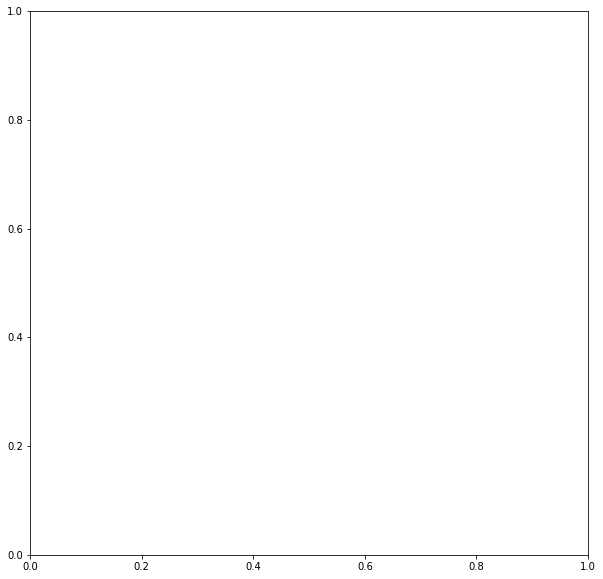

In [32]:

#cm = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
ls = ['Non-Tumorous','Validation', 'Tumorous'] # your y labels()
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
fig, ax = plt.subplots(figsize=(10,10))
#disp.plot(xticks_rotation=50, ax = ax)
plt.show()

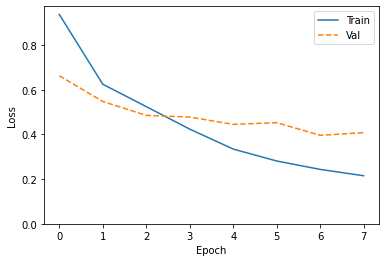

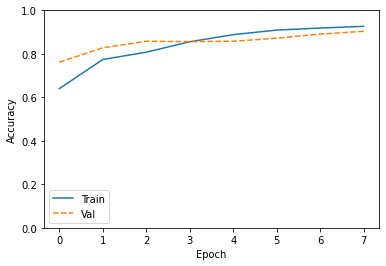

In [33]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()  
    except:
      pass
plot_metrics(hist)


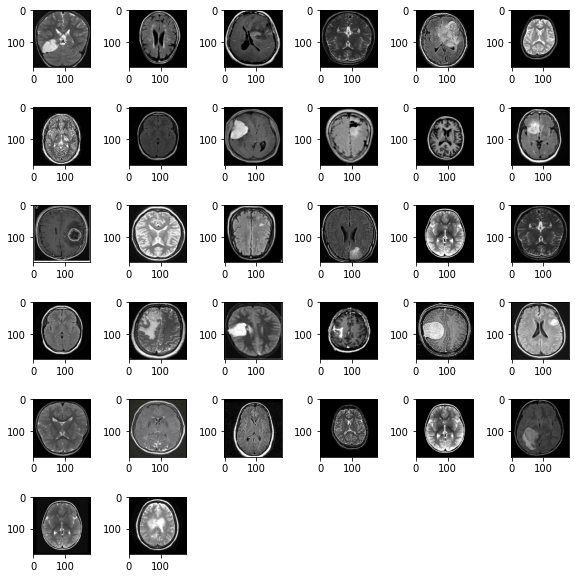

In [40]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.subplots_adjust(hspace= 0.7)
        plt.imshow(images[i].numpy().astype("uint8"))
        act_lab = labels.numpy()[i]
        #pred_lab = predictions[i]
        #title = "Actual {}\n Pred {}".format(act_lab,pred_lab)
        #plt.title(title)
       # plt.axis("off")
    plt.show()